In [44]:
import pandas as pd


df = pd.read_csv('data/df_final.csv')

df.shape
df.columns

# Asignamos typos a las columnas
# Index(['year', 'geo', 'hh', 'house_disp', 'employ_hash_education',
#        'employ_total', 'employ_f', 'employ_m', 'not_employ_total',
#        'population', 'child_avg_allwk', 'child_avg_allnowk', 'child_avg'],
#       dtype='object')
df['geo'] = df['geo'].astype('category')
df['hh'] = df['hh'].astype('category')

df['house_disp'] = pd.to_numeric(df['house_disp'])
df['employ_hash_education'] = pd.to_numeric(df['employ_hash_education'])
df['employ_total'] = pd.to_numeric(df['employ_total'])
df['employ_f'] = pd.to_numeric(df['employ_f'])
df['employ_m'] = pd.to_numeric(df['employ_m'])
df['not_employ_total'] = pd.to_numeric(df['not_employ_total'])
df['population'] = pd.to_numeric(df['population'])
df['child_avg_allwk'] = pd.to_numeric(df['child_avg_allwk'])
df['child_avg_allnowk'] = pd.to_numeric(df['child_avg_allnowk'])
df['child_avg'] = pd.to_numeric(df['child_avg'])

df.shape

# Eliminamos filas con valores a 0
df = df[df['employ_total'] != 0]
df = df[df['employ_f'] != 0]
df = df[df['employ_m'] != 0]
df = df[df['not_employ_total'] != 0]
df = df[df['population'] != 0]

df.shape

# obtemenos un DF solo con los hh=total
df_total = df[df['hh'] == 'TOTAL']

# eliminamos las filas con hh=TOTAL
df = df[df['hh'] != 'TOTAL']
print(df['hh'].unique())
# trasladamos las filas con hh=TOTAL el campo population a cada geo y year para poder hacer calculos
for row in df_total.itertuples():
    total = df_total.loc[(df['geo'] == row.geo) & (df['year'] == row.year), 'population']
    df.loc[(df['geo'] == row.geo) & (df['year'] == row.year), 'population'] = total

df.head(10)

df.shape


['HHC_22', 'HHC_21', 'HHC_32', 'HHC_31', 'HHC_42', 'HHC_41']
Categories (7, object): ['HHC_21', 'HHC_22', 'HHC_31', 'HHC_32', 'HHC_41', 'HHC_42', 'TOTAL']


(3279, 13)

array([[<AxesSubplot: title={'center': 'year'}>,
        <AxesSubplot: title={'center': 'population'}>,
        <AxesSubplot: title={'center': 'house_disp'}>],
       [<AxesSubplot: title={'center': 'employ_hash_education'}>,
        <AxesSubplot: title={'center': 'employ_total'}>,
        <AxesSubplot: title={'center': 'not_employ_total'}>],
       [<AxesSubplot: title={'center': 'employ_f'}>,
        <AxesSubplot: title={'center': 'employ_m'}>,
        <AxesSubplot: title={'center': 'child_avg_allwk'}>],
       [<AxesSubplot: title={'center': 'child_avg_allnowk'}>,
        <AxesSubplot: title={'center': 'child_avg'}>, <AxesSubplot: >]],
      dtype=object)

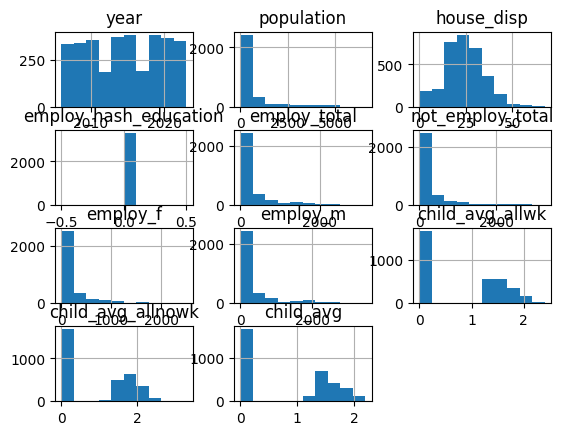

In [45]:
# mostramos estadísticos más importantes

df.describe()

# boxplot
df.hist()


<AxesSubplot: xlabel='geo'>

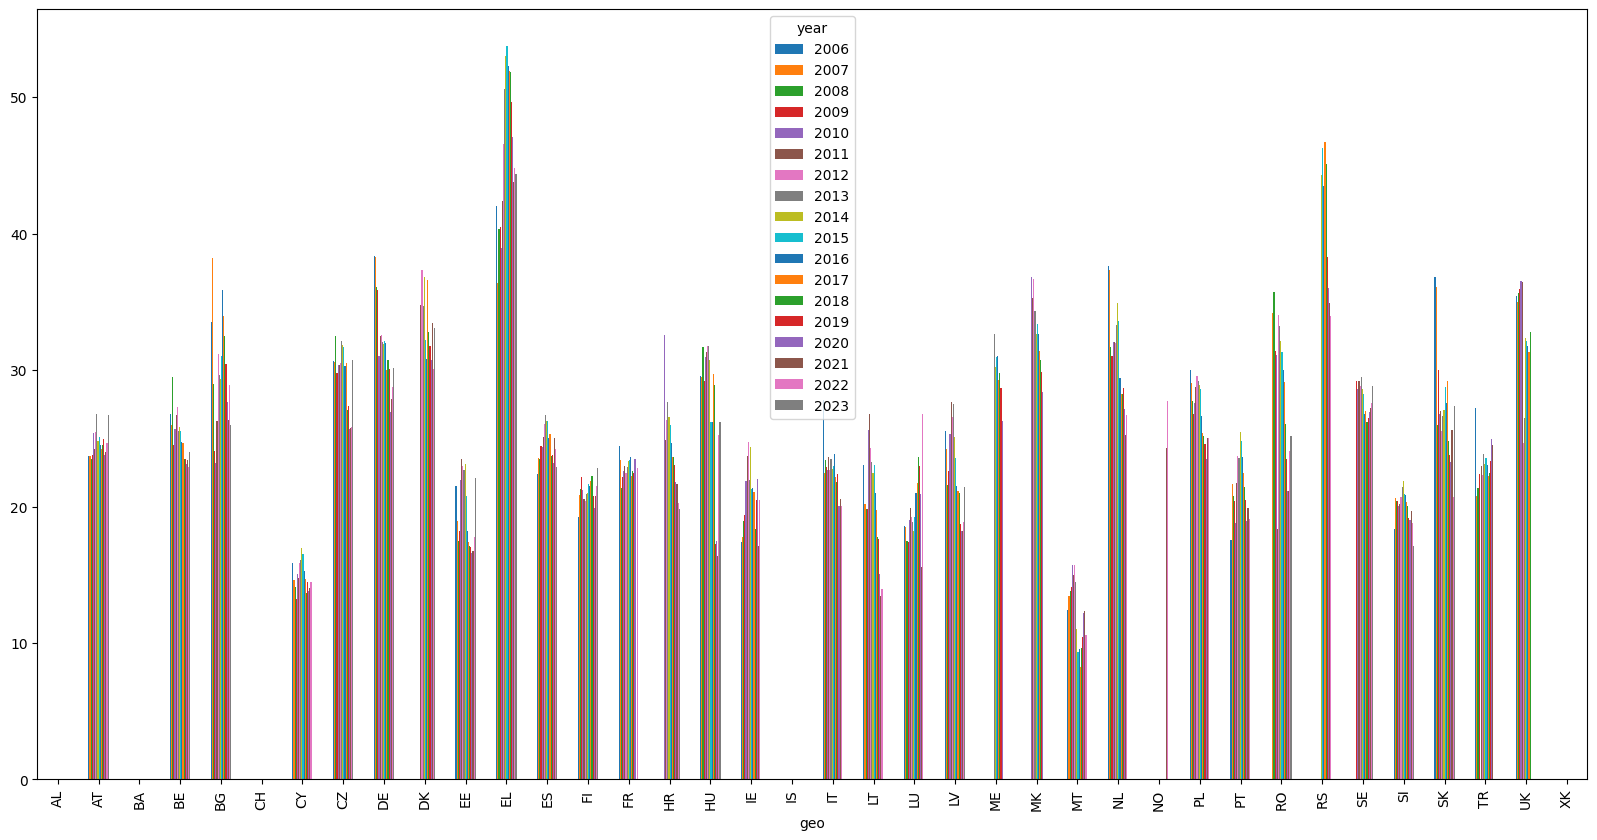

In [46]:
# mostramos comparativa de house_disp por países y años

df.groupby(['geo', 'year'])['house_disp'].mean().unstack().plot(kind='bar', figsize=(20, 10))



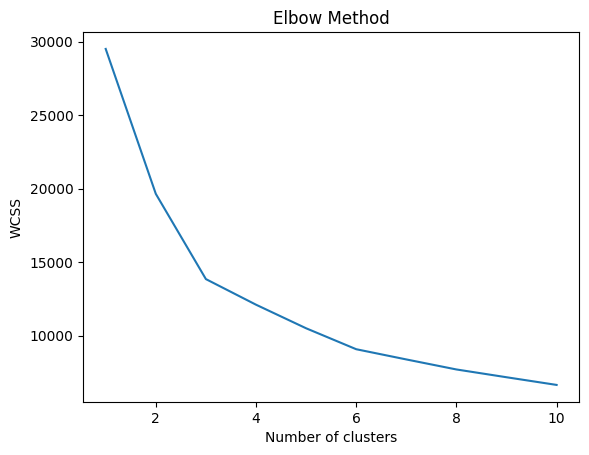

In [47]:
# BUSCAMOS CLUSTERS EN EL DATASET

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# seleccionamos las columnas que nos interesan
# convertimos hh para poder hacer clusters
df_clusters = df.copy()
df_clusters['hh'] = df_clusters['hh'].cat.codes
df_clusters['geo'] = df_clusters['geo'].cat.codes

X = df_clusters[['hh','geo', 'house_disp', 'employ_hash_education', 'employ_total',  'not_employ_total', 'population', 'child_avg_allwk', 'child_avg_allnowk', 'child_avg']]
X.shape

# normalizamos los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# buscamos el número de clusters óptimo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()




/var/folders/l7/cml0r27x3rz0jrl19v3ft1t40000gn/T/ipykernel_5992/93354284.py:11: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/var/folders/l7/cml0r27x3rz0jrl19v3ft1t40000gn/T/ipykernel_5992/93354284.py:14: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



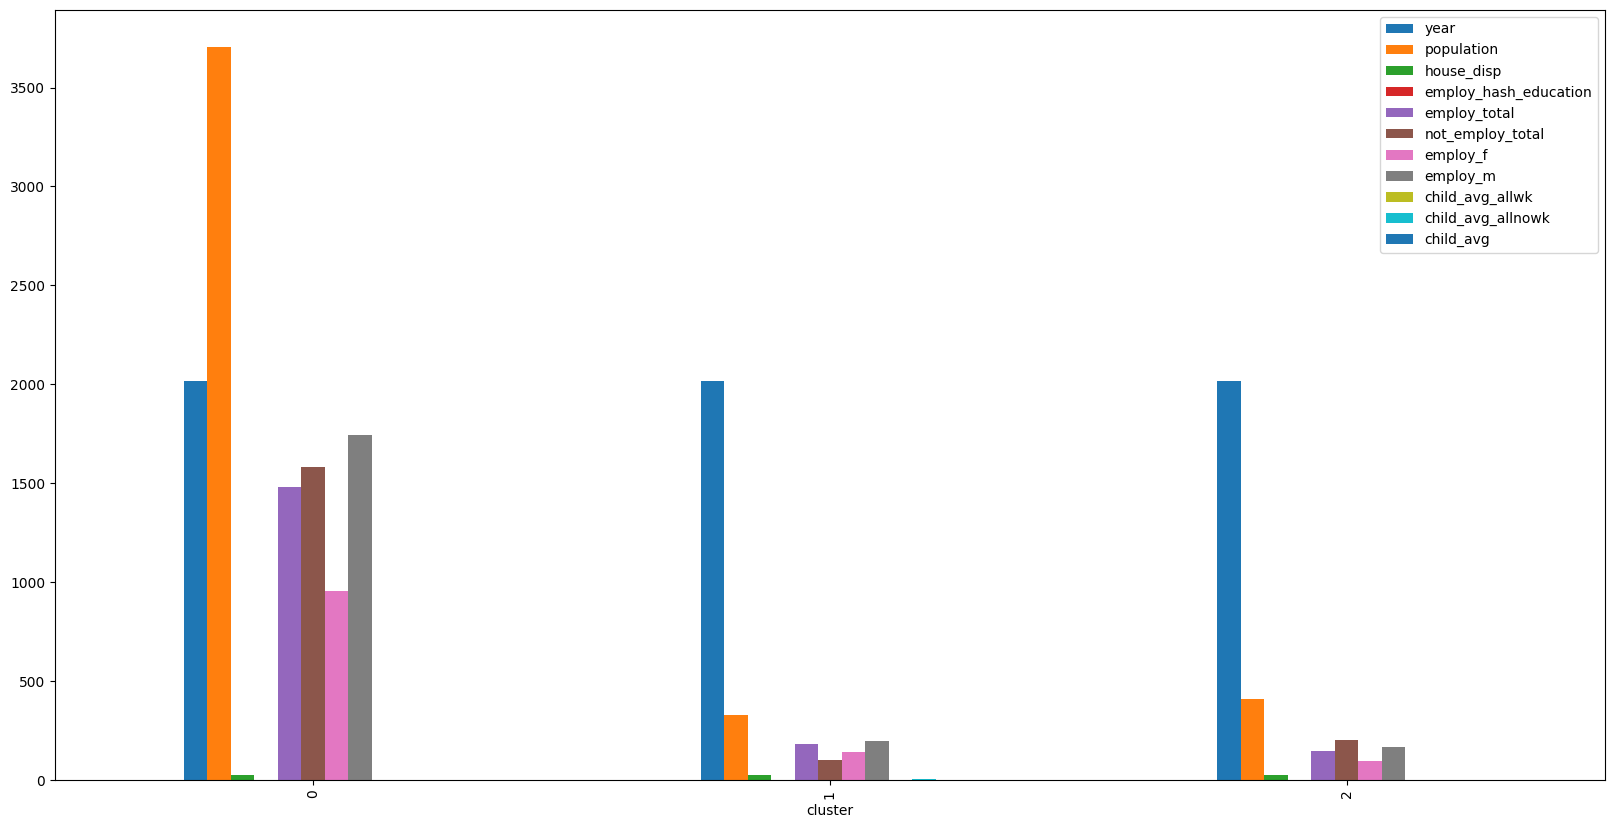

In [48]:

# aplicamos kmeans con 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)

# obtenemos los clusters
clusters = kmeans.fit_predict(X_scaled)

# añadimos los clusters al dataset
df['cluster'] = clusters

# mostramos los clusters
df.groupby('cluster').mean()

# mostramos los clusters en un gráfico
df.groupby('cluster').mean().plot.bar(figsize=(20, 10))
plt.show()


In [49]:
import plotly.express as px
 
fig = px.scatter_3d(df, x='employ_total', y='house_disp', z='employ_hash_education',
                    color='child_avg', symbol='child_avg')
fig.show()


In [50]:
# plot hh vs population year and geo in a flow chart
#agrupamos por pais, house_disp, año, employ_total, population
df_grouped = df.copy()
df_grouped = df_grouped.groupby([ 'hh', 'year']).sum().reset_index()

#especificamos los valores numericos
df_grouped['house_disp'] = pd.to_numeric(df_grouped['house_disp'])
df_grouped['employ_total'] = pd.to_numeric(df_grouped['employ_total'])
df_grouped['population'] = pd.to_numeric(df_grouped['population'])


#ajustamos los rangos de x e y
x_min = max(df_grouped['house_disp'].min() * 0.9, 1)  # Asegurarse de que x_min sea positivo
x_max = df_grouped['house_disp'].max() * 1.1
x_range = [x_min, x_max]
print(x_range)
y_range = [df_grouped['employ_total'].min() * 0.9, df_grouped['employ_total'].max() * 1.1]
print(y_range)


fig = px.scatter(df_grouped, x='house_disp', y='employ_total', animation_frame='year', animation_group='hh',
           size='population', color='hh', hover_name='hh',
           log_x=True, size_max=55, range_x=x_range, range_y=y_range)
fig.show()

# Guardar el gráfico en un archivo HTML
import plotly.offline as pyo
name = "hh_year"
filename = f'src/_includes/plot_{name}.html'
pyo.plot(fig, filename=filename, auto_open=False)
 
# Guardamos json con los datos
import json
hh_year = df_grouped.to_dict(orient='records')

# Crea el diccionario final para JSON
universe = {"data": hh_year}

# Escribe el diccionario a un archivo JSON
with open('src/_data/hh_year.json', 'w') as f:
    json.dump(universe, f, indent=4)


/var/folders/l7/cml0r27x3rz0jrl19v3ft1t40000gn/T/ipykernel_5992/2447056325.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



[1, 1235.5708095238094]
[0.0, 21552.23675848751]


In [53]:
# plot hh vs population year and geo in a flow chart

df_filtered = df[df['hh'] == 'HHC_21']

print(df_filtered.head(50))
#ajus
x_min = max(df_filtered['employ_total'].min() * 0.9, 1)  # Asegurarse de que x_min sea positivo
x_max = df_filtered['employ_total'].max() * 1.1
x_range = [x_min, x_max]

print(df_filtered['geo'].unique().tolist())

y_range = [df_filtered['house_disp'].min() * 0.9, df_filtered['house_disp'].max() * 1.1]


fig = px.scatter(df_filtered, x='employ_total', y='house_disp', animation_frame='year', animation_group='geo',
           size='population', color='geo', hover_name='geo',
           log_x=True, size_max=55, range_x=x_range, range_y=y_range)
fig.show()

# Guardar el gráfico en un archivo HTML
import plotly.offline as pyo
pyo.plot(fig, filename='src/_includes/hh_geo_years.html')

import json

# normalizamos los datos de 0 a 100
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(1, 100))
df_normalized = df.copy()
X = df_normalized[['house_disp', 'employ_hash_education', 'employ_total', 'not_employ_total', 'employ_f', 'employ_m', 'population']]
X_scaled = scaler.fit_transform(X)
print(X_scaled)
#aplicamos dentro del df los valores normalizados
#df_normalized['house_disp'] = X_scaled[:,0]
df_normalized['employ_hash_education'] = X_scaled[:,1]
df_normalized['employ_total'] = X_scaled[:,2]
df_normalized['not_employ_total'] = X_scaled[:,3]
df_normalized['employ_f'] = X_scaled[:,4]
df_normalized['employ_m'] = X_scaled[:,5]
df_normalized['population'] = X_scaled[:,6]

df_normalized.describe()

# hh_year = df_normalized.to_dict(orient='records')
hh_year = df_normalized.to_dict(orient='records')

# Crea el diccionario final para JSON
universe = {"data": hh_year}

# Escribe el diccionario a un archivo JSON
with open('src/_data/universe.json', 'w') as f:
    json.dump(universe, f, indent=4)


     year geo      hh  population  house_disp  employ_hash_education  \
632  2006  AT  HHC_21   60.729412   30.933333                      0   
633  2007  AT  HHC_21   62.123529   33.700000                      0   
634  2008  AT  HHC_21   57.283333   29.266667                      0   
635  2009  AT  HHC_21   59.052941   30.900000                      0   
636  2010  AT  HHC_21   55.166667   31.633333                      0   
637  2011  AT  HHC_21   52.538889   30.133333                      0   
638  2012  AT  HHC_21   55.794118   31.100000                      0   
639  2013  AT  HHC_21   55.172222   36.066667                      0   
640  2014  AT  HHC_21   49.316667   33.333333                      0   
641  2015  AT  HHC_21   51.382353   30.133333                      0   
642  2016  AT  HHC_21   51.761111   31.733333                      0   
643  2017  AT  HHC_21   55.925000   30.366667                      0   
644  2018  AT  HHC_21   45.510526   34.300000                   

[[48.29673591  1.          5.20244232 ...  4.24316866  5.55711831
   6.34076013]
 [49.21721068  1.          5.30669301 ...  4.28507722  5.71577957
   6.42487631]
 [49.49139466  1.          5.27215063 ...  4.42208595  5.57242107
   6.51322615]
 ...
 [ 1.          1.          1.17978036 ...  1.15549091  1.18712918
   1.22455387]
 [ 1.          1.          1.44331488 ...  1.38932031  1.45964477
   1.46232134]
 [ 1.          1.          4.70952285 ...  4.48177067  4.77779785
   5.88965678]]
